## Seizure detection using Hybrid SNN ####

### Importing Dependencies and Defining Patient Metadata

This initial notebook cell sets up the environment, loads required libraries, and defines the metadata for the subset of CHB-MIT patients used in the pipeline.

#### 1. Inspecting Kaggle Input Directory
```python
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
```

#### 2. Importing All Required Libraries

This block loads all the scientific, signal-processing, plotting, and deep-learning libraries used throughout the notebook:
MNE for EDF reading and EEG channel management
NumPy, Pandas, SciPy for numerical operations
PyTorch + snntorch for SNN models, training loops, and surrogate gradient learning
Matplotlib / Seaborn for plotting
scikit-learn for metrics and train/validation splits
h5py, gc, warnings, contextlib for data handling and housekeeping
Utility modules (collections, typing, re) for data structures and parsing
PdfPages for exporting multi-page PDF raster plots (optional)
These imports prepare the environment for:
Loading EDFs
Cleaning and processing EEG channels
Sliding-window dataset creation
Spike encoding
Hybrid SNN training, evaluation, and visualisation

#### 3. Defining Patient Dictionaries and Seizure Annotations
```python 
patient = {
 "patient21": { ... },
 "patient24": { ... },
 ...
}
```

This dictionary encodes the metadata needed to drive the end-to-end preprocessing pipeline:
"edf" — list of EDF filenames for each patient
"seizures" — corresponding seizure onset/offset annotations in sample indices
Each "seizures" entry may include:

Single start/end pairs, e.g. [1288, 1344]

Multiple seizures per file using flattened lists, e.g. [480,505,2451,2476]
This structure is used throughout the workflow to:
Normalise seizure intervals
Build seizure labels for sliding windows


In [20]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#import pyedflib
import mne
import os, time
import math
from collections import Counter
from typing import Tuple, Optional, List
import numpy as np
import pandas as pd
import h5py
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import atexit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import snntorch as snn
from snntorch import surrogate
from contextlib import nullcontext
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_recall_fscore_support, f1_score,accuracy_score
from sklearn.model_selection import train_test_split
from collections import deque, Counter, defaultdict
from typing import Tuple, Optional, Callable, Dict, List
from scipy.signal import lfilter
import warnings
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import re
patient = {
 "patient21": {
  "edf": [ "chb21_19.edf", "chb21_20.edf", "chb21_21.edf", "chb21_22.edf"],
  "seizures": [ [1288, 1344], [2627, 2677], [2003, 2074], [2553, 2565]]
 },
 "patient24": {
  "edf": ["chb24_01.edf", "chb24_03.edf", "chb24_04.edf", "chb24_09.edf", "chb24_11.edf", "chb24_13.edf", "chb24_14.edf", "chb24_15.edf", "chb24_17.edf", "chb24_21.edf"],
  "seizures": [[480,505,2451,2476], [231,260,2883,2908], [1088,1120,1411,1438,1745,1764], [1745,1764], [3527,3597], [3288,3304], [1939,1966], [3552,3569], [3515,3581], [2804,2872]]
 },
 "patient03": {
  "edf": ["chb03_01.edf", "chb03_02.edf", "chb03_03.edf", "chb03_04.edf"],
  "seizures": [[362, 414], [731, 769], [432, 501], [2162, 2214]]
 },
 "patient01": {
  "edf": ["chb01_03.edf", "chb01_04.edf", "chb01_15.edf", "chb01_16.edf"],
  "seizures": [[2996, 3036], [1467, 1494], [1732, 1772], [1015, 1066]]
 },
 "patient17": {
  "edf": ["chb17a_03.edf", "chb17a_04.edf", "chb17b_63.edf"],
  "seizures": [[2282, 2372], [3025, 3140], [3136, 3224]]
 },
 "patient14": {
  "edf": ["chb14_03.edf", "chb14_04.edf", "chb14_06.edf", "chb14_11.edf", "chb14_17.edf", "chb14_18.edf", "chb14_27.edf"],
  "seizures": [[1986,2000], [1372,1392,2817,2839], [1911,1925],[1838,1879], [3239,3259], [1039,1061], [2833,2849]]
 }
}

#Parameters
Setting window size =128 (samples = 0.5 second), overlap = 64. 
if 33% of the samples belong to Seizure dataset, the whole window is labelled as Seizure 


In [21]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
# --- Config ---
DATA_PATH =  "C:/Users/30060006/downloads/"
OUT_PATH = "./"
WINDOW_SIZE = 128
OVERLAP = 64
THRESHOLD = 0.33
EXPECTED_CHANNELS = 19
SAMPLE_RATIO = 0.25
BATCH_SIZE = 64          
EPOCHS = 100
DELTAX = 0.2

Device: cpu


### Utility Functions Overview

This notebook implements the full preprocessing and spike-encoding pipeline for EEG-based seizure detection, starting from raw EDF files and ending with spike-encoded windows ready for SNN / ConvSNN training. The code is structured into several stages:

1. **Channel cleaning and canonicalisation**  
   - Creates the output directory (`OUT_PATH`) and defines constants for excluding non-EEG channels (e.g. ECG, EMG, photic, reference electrodes).  
   - `canonicalize_name` normalises channel labels (strip whitespace, uppercase, remove dedup suffixes) so that channels can be consistently matched across EDFs and patients.  
   - `is_nonempty_channel` checks whether a channel contains meaningful data (finite values, not all zeros, and variance above a small threshold), helping to discard flat or invalid signals.  
   - `drop_non_eeg_channels` removes junk and non-EEG channels based on label patterns and exclusion keywords.  
   - `rename_duplicates` detects duplicate channel names within an EDF and appends suffixes (e.g. `_0`, `_1`) so MNE can index them safely, while preserving a canonical name via `canonicalize_name`.

2. **Seizure annotation handling**  
   - `normalize_seizure_intervals` converts seizure annotations into a clean list of `(start, end)` tuples in seconds, handling both flat lists and nested list formats and fixing reversed pairs when necessary.

3. **Discovery of common non-empty channels**  
   - `discover_common_nonempty_channels` iterates over all patients and their EDF files to:
     - Read each EDF with MNE, drop non-EEG channels, rename duplicates, and identify which canonical channels contain non-empty data in that file.
     - Compute, per patient, the intersection of non-empty channels across *all* their EDFs.
     - Finally intersect these per-patient sets to obtain a global list of `COMMON_CHANNELS` that are present and non-empty in every patient considered.  
   - This ensures that downstream models see a fixed, consistent channel layout across the entire dataset.

4. **Preprocessing and saving standardised NPZ files**  
   - `preprocess_and_save` loops over all patients and EDF files to:
     - Load the raw EDF, clean channels, and rename duplicates as above.  
     - Map canonical channel names to their indices and verify that every `COMMON_CHANNEL` is present and non-empty in that recording.  
     - Extract only the common channels (in a fixed global order), and perform per-channel z-score normalisation.  
     - Save each recording as a compressed `.npz` file containing:
       - `data`: normalised EEG array `(channels, time)`  
       - `sfreq`: sampling frequency  
       - `seizures`: normalised seizure intervals  
       - `channel_names`: the ordered list of common channel labels  

5. **Windowing, labelling, and dataset construction**  
   - `label_window` assigns a binary seizure label to a sliding window based on the fraction of time that overlaps with any seizure interval. A window is labelled seizure (`1`) if the overlap exceeds a configurable threshold, otherwise non-seizure (`0`).  
   - `build_dataset_from_npz` loads all `.npz` files, optionally re-z-scores channels, and creates a windowed dataset:
     - Slides a fixed-length window with a given overlap across time.
     - Uses `label_window` to label each window.
     - Optionally tracks a `group` ID (e.g. `patient_file`) for later per-recording post-processing.  
   - Returns `X_all` (continuous EEG windows), `y_all` (labels), and `groups` (optional group IDs).

6. **Class balancing**  
   - `balance_to_ratio` builds a class-balanced dataset with a target positive (seizure) ratio:
     - Oversamples seizure windows with replacement if needed.
     - Undersamples non-seizure windows without replacement.
     - Returns the balanced `X_bal`, `y_bal`, the original indices used, and summary statistics.

7. **Hybrid spike encoders (Sigma–Delta and Poisson rate)**  
   - `sigma_delta_encode_1d` implements a simple sigma–delta (Δ-modulation) encoder, emitting a spike when the signal exceeds a running state `s`, which is then updated by a leak term `delta`.  
   - `poisson_rate_encode_1d` converts a continuous signal into spikes using a sigmoid nonlinearity followed by Bernoulli sampling (Poisson-like rate coding).  
   - `HybridSpikeDataset` (PyTorch `Dataset`) takes continuous z-scored windows `(N, C, T)` and:
     - Encodes each channel with both sigma–delta and rate coding, then concatenates them into `(2C, T)`.  
     - Applies optional spike-domain augmentations:
       - Channel dropout (randomly silencing entire channels).
       - Temporal masking (zeroing contiguous time segments).
       - Temporal max-pooling to reduce the time dimension.  
     - Returns spike tensors in shape `(T, 2C)` plus integer labels, suitable for spiking neural network models.

8. **Visualisation: spike rasters and seizure/non-seizure examples**  
   - `plot_spike_raster_with_label`, `plot_spike_raster`, and `plot_multiple_spike_rasters` provide convenience functions for visualising spike trains as raster plots for individual windows or multiple seizure/non-seizure examples.  
   - `plot_spike_raster_ax` is a reusable helper that draws a raster on a given Matplotlib axis.  
   - `save_seizure_nonseizure_pair` scans a PyTorch `DataLoader` for one seizure and one non-seizure sample, plots them side-by-side, and saves the figure as a high-resolution PNG.  
   - `save_seizure_nonseizure_pairs` generalises this to multiple pairs, creating a directory of paired seizure/non-seizure raster images for qualitative inspection or inclusion in figures.


In [22]:
os.makedirs(OUT_PATH, exist_ok=True)

EXCLUDE_KEYWORDS = ["ECG", "EMG", "PHOT", "A1", "A2"]  # non-EEG junk
ZERO_TOL   = 1e-8   # absolute magnitude considered "zero"
VAR_TOL    = 1e-12  # near-zero variance implies empty/flat channel

def canonicalize_name(ch: str) -> str:
    """
    Canonical channel name used for matching across files/patients.
    - Strip whitespace
    - Uppercase
    - Remove the suffix pattern we may add for dedup (e.g., '_7')
    """
    ch = ch.strip().upper()
    ch = re.sub(r"_(\d+)$", "", ch)
    return ch

def is_nonempty_channel(x: np.ndarray, zero_tol=ZERO_TOL, var_tol=VAR_TOL) -> bool:
    """
    Decide if a channel has meaningful data.
    - Not all ~zero
    - Finite and with variance above small threshold
    """
    if x.ndim != 1:
        x = x.ravel()
    if not np.all(np.isfinite(x)):
        # if NaNs exist but there is still variance on finite subset, consider non-empty
        x = x[np.isfinite(x)]
        if x.size == 0:
            return False
    if np.all(np.isclose(x, 0.0, atol=zero_tol)):
        return False
    if float(np.var(x)) <= var_tol:
        return False
    return True



def drop_non_eeg_channels(raw: mne.io.BaseRaw):
    # Remove explicit garbage labels like "-", "--0", etc.
    junk = [ch for ch in raw.ch_names if ch.strip() in ["-", "--0", "--1", "--2", "--3", "--4"]]
    if junk:
        raw.drop_channels(junk)
    # Remove channels with unwanted keywords
    bad = [ch for ch in raw.ch_names if any(k in ch.upper() for k in EXCLUDE_KEYWORDS)]
    if bad:
        raw.drop_channels(bad)



def rename_duplicates(raw: mne.io.BaseRaw):
    """
    If the EDF has duplicate channel labels, MNE will keep them, but this can break indexing later.
    We'll append _{i} to duplicates so names are unique while we still maintain a canonical map
    (by stripping the suffix later via canonicalize_name).
    """
    seen = {}
    new_names = {}
    for i, ch in enumerate(raw.ch_names):
        if ch not in seen:
            seen[ch] = 1
        else:
            seen[ch] += 1
            new_names[ch] = None  # placeholder; we'll fill after counting

    # If duplicates exist, we must rebuild unique names:
    if any(v > 1 for v in seen.values()):
        counts = {}
        unique_map = {}
        for i, ch in enumerate(raw.ch_names):
            counts[ch] = counts.get(ch, 0) + 1
            if seen[ch] > 1:
                unique_map[ch, counts[ch]] = f"{ch}_{counts[ch]-1}"  # _0, _1, ...
        # Final pass to form rename dict
        rename_dict = {}
        # track per-name index again
        idx_per_name = {}
        for ch in raw.ch_names:
            idx_per_name[ch] = idx_per_name.get(ch, 0) + 1
            if seen[ch] > 1:
                rename_dict[ch] = None  # mne needs unique keys; handle via iterative mapping below
        # mne requires a one-to-one rename; perform via direct set (iterate indices)
        for i, ch in enumerate(raw.ch_names):
            if seen[ch] > 1:
                n = idx_per_name[ch]
                raw.rename_channels({ch: unique_map[(ch, n)]})
    # else: nothing to do



def normalize_seizure_intervals(sz_list):
    """
    Normalize seizure annotations to a list of (start, end) tuples.
    Handles both flat lists and nested lists. Fixes reversed pairs.
    """
    normalized = []
    if sz_list is None:
        return normalized

    # Flat list
    if isinstance(sz_list, (list, tuple)) and len(sz_list) > 0 and all(isinstance(x, (int, float)) for x in sz_list):
        for i in range(0, len(sz_list), 2):
            if i + 1 >= len(sz_list): break
            s, e = float(sz_list[i]), float(sz_list[i + 1])
            if e < s: s, e = e, s
            if e > s: normalized.append((s, e))
        return normalized

    # List of pairs
    if isinstance(sz_list, (list, tuple)) and len(sz_list) > 0 and all(isinstance(x, (list, tuple)) for x in sz_list):
        for pair in sz_list:
            if len(pair) < 2: continue
            s, e = float(pair[0]), float(pair[1])
            if e < s: s, e = e, s
            if e > s: normalized.append((s, e))
        return normalized

    # Unexpected
    print(f"⚠️ Unexpected seizure list format: {sz_list}")
    return normalized



def discover_common_nonempty_channels(patient_dict, data_path):
    """
    For each patient:
      - intersect non-empty EEG channel canonical names across ALL that patient's EDFs
    Then:
      - intersect across all patients -> COMMON_CHANNELS
    Returns: sorted list of canonical names
    """
    per_patient_sets = []

    print("\n=== PASS 1: Discovering non-empty channels per patient ===\n")

    for pname, pdata in patient_dict.items():
        patient_good_set = None
        edf_list = pdata.get("edf", [])
        if len(edf_list) == 0:
            print(f"⚠️ {pname}: no EDF files listed, skipping.")
            continue

        print(f"\n🧠 Checking patient: {pname} ({len(edf_list)} EDF files)")
        for file_idx, edf_file in enumerate(edf_list, start=1):
            edf_path = os.path.join(data_path, edf_file)
            print(f"   ▶️ [{file_idx}/{len(edf_list)}] Reading {edf_file} ...", end="", flush=True)

            if not os.path.exists(edf_path):
                print(f" ❌ Missing, skipping.")
                continue

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)
                try:
                    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
                except Exception as e:
                    print(f" ❌ Error reading EDF ({e}), skipping.")
                    continue

            drop_non_eeg_channels(raw)
            rename_duplicates(raw)

            # Build canonical->indices map
            canon_to_indices = {}
            for idx, ch in enumerate(raw.ch_names):
                canon = canonicalize_name(ch)
                canon_to_indices.setdefault(canon, []).append(idx)

            data = raw.get_data()
            good_here = set()

            for canon, idxs in canon_to_indices.items():
                # Channel counted good if any duplicate index has data
                if any(is_nonempty_channel(data[ii, :]) for ii in idxs):
                    good_here.add(canon)

            print(f" found {len(good_here)} non-empty channels.")
            if not good_here:
                print(f"   ⚠️ All channels empty or invalid in {edf_file}")

            # Update per-patient intersection
            if patient_good_set is None:
                patient_good_set = good_here
            else:
                patient_good_set &= good_here

        # Done with this patient
        if not patient_good_set:
            print(f"⚠️ No consistent non-empty channels discovered for {pname}; skipping in global intersection.")
            continue

        per_patient_sets.append(patient_good_set)
        print(f" {pname}: {len(patient_good_set)} channels non-empty across all their EDFs.")

    if len(per_patient_sets) == 0:
        raise RuntimeError("No patients yielded non-empty channel sets. Check data/filters.")

    common = set.intersection(*per_patient_sets)
    COMMON_CHANNELS = sorted(common)

    print("\n=== PASS 1 COMPLETE ===")
    print(f"COMMON_CHANNELS across all patients: {len(COMMON_CHANNELS)}")
    print(COMMON_CHANNELS)
    return COMMON_CHANNELS



def preprocess_and_save(patient_dict, data_path, out_path, common_channels):
    saved = 0
    for pname, pdata in patient_dict.items():
        for i, edf_file in enumerate(pdata["edf"]):
            sz_times = pdata["seizures"][i] if i < len(pdata["seizures"]) else []
            seizure_intervals = normalize_seizure_intervals(sz_times)

            edf_path = os.path.join(data_path, edf_file)
            if not os.path.exists(edf_path):
                print(f"⚠️ Missing EDF, skipping save: {edf_file}")
                continue

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)
                raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

            drop_non_eeg_channels(raw)
            rename_duplicates(raw)

            # Build canonical map again
            canon_to_indices = {}
            for idx, ch in enumerate(raw.ch_names):
                canon = canonicalize_name(ch)
                canon_to_indices.setdefault(canon, []).append(idx)

            # Verify we can supply all COMMON_CHANNELS and that each chosen index is non-empty
            data = raw.get_data()
            chosen_indices = []
            missing = []
            for canon in common_channels:
                idxs = canon_to_indices.get(canon, [])
                # pick the first non-empty occurrence
                pick = None
                for ii in idxs:
                    if is_nonempty_channel(data[ii, :]):
                        pick = ii
                        break
                if pick is None:
                    missing.append(canon)
                else:
                    chosen_indices.append(pick)

            if missing:
                print(f"⚠️ {pname}/{edf_file}: missing or empty common channels {missing}; skipping this file.")
                continue

            # Slice to COMMON_CHANNELS in fixed, global order
            data_sel = data[chosen_indices, :]  # (len(common_channels), T)
            # Per-channel z-score
            mu  = data_sel.mean(axis=1, keepdims=True)
            sig = data_sel.std(axis=1, keepdims=True) + 1e-6
            data_norm = (data_sel - mu) / sig

            sfreq = int(raw.info['sfreq'])
            out_file = os.path.join(out_path, f"{pname}_{edf_file.replace('.edf','')}.npz")
            np.savez_compressed(
                out_file,
                data=data_norm.astype(np.float32),
                sfreq=sfreq,
                seizures=np.array(seizure_intervals, dtype=object),
                channel_names=np.array(common_channels, dtype=object)
            )
            saved += 1
            print(f"Saved: {out_file} | C={data_norm.shape[0]} (COMMON) | fs={sfreq} | {len(seizure_intervals)} seizure intervals")
    if saved == 0:
        print("⚠️ No files saved. Check COMMON_CHANNELS/filters.")
    else:
        print(f"\nCompleted. Files saved: {saved}")


    
def label_window(start_sample: int, seizure_intervals, sfreq: int, win_size: int, threshold: float) -> int:
    win_start_sec = start_sample / float(sfreq)
    win_end_sec   = (start_sample + win_size) / float(sfreq)
    # ensure list of pairs
    if isinstance(seizure_intervals, np.ndarray):
        seizure_intervals = seizure_intervals.tolist()
    if len(seizure_intervals) and isinstance(seizure_intervals[0], (int, float)):
        # flat -> pairs
        seizure_intervals = [(seizure_intervals[i], seizure_intervals[i+1])
                             for i in (range(0, len(seizure_intervals), 2))]
    total_overlap = 0.0
    for st, en in seizure_intervals:
        if st == 0 and en == 0: 
            continue
        overlap = max(0.0, min(win_end_sec, float(en)) - max(win_start_sec, float(st)))
        total_overlap += overlap
    frac = total_overlap / (win_size / float(sfreq))
    return int(frac >= threshold)


def build_dataset_from_npz(npz_dir: str, window_size=WINDOW_SIZE, overlap=OVERLAP, threshold=0.30,
                           collect_groups=True):
    all_X, all_y, all_groups = [], [], []
    step = max(1, window_size - overlap)

    for fname in sorted(os.listdir(npz_dir)):
        if not fname.endswith(".npz"):
            continue
        npz_path = os.path.join(npz_dir, fname)
        data_obj = np.load(npz_path, allow_pickle=True)
        data = data_obj["data"]            # (C, T), already z-scored in your pipeline
        sfreq = int(data_obj["sfreq"])
        sz_times = data_obj["seizures"].tolist()

        # normalise again defensively if needed (safe no-op if already z-scored)
        data = (data - data.mean(axis=1, keepdims=True)) / (data.std(axis=1, keepdims=True) + 1e-6)

        for start in range(0, data.shape[1] - window_size + 1, step):
            win = data[:, start:start+window_size]           # (C, W)
            y   = label_window(start, sz_times, sfreq, window_size, threshold)
            all_X.append(win.astype(np.float32))
            all_y.append(y)
            if collect_groups:
                # group id useful for per-recording smoothing; pattern: file name
                all_groups.append(fname.replace(".npz",""))

    X_all = np.stack(all_X)         # (N, C, W)
    y_all = np.asarray(all_y, dtype=np.int64)
    groups = np.array(all_groups) if collect_groups else None
    print(f"Built windows from NPZ: X={X_all.shape}, y={y_all.shape}, Seizure%={100*np.mean(y_all):.2f}%")
    return X_all, y_all, groups


def balance_to_ratio(X, y, groups=None, target_pos_ratio=0.25, seed=42):
    """
    Build a dataset with ~target_pos_ratio positives (seizure=1) and the rest negatives (0).
    - Seizures are *oversampled with replacement* if needed.
    - Non-seizures are *undersampled without replacement*.
    - If `groups` is provided (e.g., "<patient>_<file>"), non-seizures are drawn across all patients.
    Returns: X_bal, y_bal, idx_bal (indices into original X/y), and a dict with counts.
    """
    rng = np.random.default_rng(seed)

    y = np.asarray(y).astype(int)
    N = len(y)
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]

    n_pos = len(pos_idx)
    n_neg = len(neg_idx)
    if n_pos == 0:
        raise ValueError("No seizure (positive) samples found; cannot balance to target ratio.")

    # Compute the total size needed so that positives are ~target_pos_ratio of the total.
    # We will cap total at available negatives (since we don't want to duplicate negatives).
    # Solve for total T: n_pos_needed = target_pos_ratio * T
    # If we are allowed to oversample positives, n_pos_needed can exceed n_pos.
    # We choose T so that neg_needed = (1-target_pos_ratio)*T <= n_neg
    T_max_by_negs = int(np.floor(n_neg / (1.0 - target_pos_ratio)))
    # Ensure at least all current positives
    T = max(int(np.ceil(n_pos / target_pos_ratio)), 1)
    # But we cannot exceed what negatives allow
    T = min(T, T_max_by_negs)

    # Final counts
    n_pos_needed = int(round(target_pos_ratio * T))
    n_neg_needed = T - n_pos_needed

    # Oversample positives with replacement if needed
    if n_pos_needed <= n_pos:
        pos_sel = rng.choice(pos_idx, size=n_pos_needed, replace=False)
    else:
        # take all + extra with replacement
        extra = n_pos_needed - n_pos
        pos_sel = np.concatenate([
            pos_idx,
            rng.choice(pos_idx, size=extra, replace=True)
        ])

    # Undersample negatives without replacement
    if n_neg_needed > n_neg:
        # (Shouldn't happen due to T cap, but guard anyway)
        n_neg_needed = n_neg
    neg_sel = rng.choice(neg_idx, size=n_neg_needed, replace=False)

    # Combine and shuffle
    idx_bal = np.concatenate([pos_sel, neg_sel])
    rng.shuffle(idx_bal)

    X_bal = X[idx_bal]
    y_bal = y[idx_bal]

    info = {
        "total": len(idx_bal),
        "positives": int(np.sum(y_bal == 1)),
        "negatives": int(np.sum(y_bal == 0)),
        "pos_ratio": float(np.mean(y_bal == 1)),
        "n_pos_available": n_pos,
        "n_neg_available": n_neg,
    }
    return X_bal, y_bal, idx_bal, info


# ============================================================
# Dual encoders: Sigma–Delta (Δ-mod) and Poisson rate
# ============================================================
def sigma_delta_encode_1d(x: np.ndarray, delta: float = 0.3) -> np.ndarray:
    s = 0.0
    out = np.zeros_like(x, dtype=np.float32)
    for t, v in enumerate(x):
        spk = 1.0 if v > s else 0.0
        s = s + spk - delta
        out[t] = spk
    return out

def poisson_rate_encode_1d(x: np.ndarray, max_rate: float = 1.0) -> np.ndarray:
    p = 1.0 / (1.0 + np.exp(-x))           # sigmoid into [0,1]
    p = np.clip(p * max_rate, 0.0, 1.0)    # cap probability
    rnd = np.random.rand(*p.shape)
    return (rnd < p).astype(np.float32)

# ============================================================
# Dataset that builds BOTH encodings on-the-fly and concatenates channels
# ============================================================
class HybridSpikeDataset(Dataset):
    """
    Returns spikes as (T, 2C): [sigma-delta; rate], labels as int.
    """
    def __init__(self, X_cont, y, delta=0.1, max_rate=1.0,
                 time_pool=1, channel_dropout_p=0.0, time_mask_prob=0.0, time_mask_len=4,
                 train=True):
        self.X = torch.tensor(X_cont, dtype=torch.float32)  # (N, C, T)
        self.y = torch.tensor(y, dtype=torch.long)
        self.delta = delta
        self.max_rate = max_rate
        self.time_pool = time_pool
        self.cd_p = channel_dropout_p if train else 0.0
        self.tm_p = time_mask_prob if train else 0.0
        self.tm_len = time_mask_len
        self.train = train

    def __len__(self): return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx].numpy()         # (C, T) continuous, z-scored
        C, T = x.shape

        # --- dual encodings ---
        spk_delta = np.stack([sigma_delta_encode_1d(x[c], delta=self.delta) for c in range(C)], axis=0)  # (C,T)
        spk_rate  = np.stack([poisson_rate_encode_1d(x[c], max_rate=self.max_rate) for c in range(C)], axis=0)  # (C,T)

        spk = np.concatenate([spk_delta, spk_rate], axis=0)  # (2C, T)
        spk = torch.tensor(spk, dtype=torch.float32)

        # --- optional spike-domain augs ---
        if self.cd_p > 0:
            mask = (torch.rand(spk.shape[0]) > self.cd_p).float()
            spk = spk * mask.view(-1, 1)
        if self.tm_p > 0 and torch.rand(1).item() < self.tm_p and spk.shape[1] > self.tm_len:
            t0 = torch.randint(0, spk.shape[1]-self.tm_len+1, (1,)).item()
            spk[:, t0:t0+self.tm_len] = 0.0

        # time max-pool (optional)
        if self.time_pool > 1:
            Ttrim = (spk.shape[1] // self.time_pool) * self.time_pool
            spk = spk[:, :Ttrim]
            spk = spk.view(spk.shape[0], -1, self.time_pool).amax(dim=2)

        # -> (T, 2C)
        spk = spk.permute(1, 0).contiguous()
        return spk, self.y[idx]


def plot_spike_raster_with_label(spikes, label, window_index=None):
    """
    Plot raster of spikes (shape: [channels, time]) and indicate seizure status.

    Parameters
    ----------
    spikes : np.ndarray
        Spike-encoded EEG segment of shape (C, L)
    label : int
        1 for seizure, 0 for non-seizure
    window_index : int, optional
        Index of the sample (used in title)
    """
    assert spikes.ndim == 2, "Expected shape (channels, time)"
    C, T = spikes.shape

    fig, ax = plt.subplots(figsize=(10, 5))

    # Build spike coordinates
    for ch in range(C):
        times = np.where(spikes[ch] > 0)[0]
        ax.vlines(times, ch - 0.4, ch + 0.4, color='black')

    ax.set_ylim(-1, C)
    ax.set_xlim(0, T)
    ax.set_yticks(range(C))
    ax.set_yticklabels([f"Ch{c+1}" for c in range(C)])
    ax.set_xlabel("Time step")
    ax.set_ylabel("Channel")
    
    title = f"Spike Raster - {'SEIZURE' if label == 1 else 'Non-Seizure'}"
    if window_index is not None:
        title += f" (Window {window_index})"
    ax.set_title(title, color='red' if label == 1 else 'black')

    # Optional: background color to indicate seizure
    if label == 1:
        ax.axvspan(0, T, color='red', alpha=0.1)

    plt.tight_layout()
    plt.show()


def plot_spike_raster(ax, spikes, label, title):
    """
    Plot a spike raster on the given axes.
    """
    C, L = spikes.shape
    for ch in range(C):
        spike_times = np.where(spikes[ch] > 0)[0]
        ax.vlines(spike_times, ch + 0.5, ch + 1.5, color='black', linewidth=0.4)

    ax.set_title(title, fontsize=9)
    ax.set_xlabel("Time")
    ax.set_ylabel("Channel")
    ax.set_ylim(0.5, C + 0.5)
    ax.set_yticks([])
    ax.grid(True, linestyle='--', alpha=0.3)
    
    
def plot_multiple_spike_rasters(X, y, num_samples=3, figsize=(12, 6)):
    """
    Plot multiple spike rasters for seizure (y=1) and non-seizure (y=0) samples.
    """
    seizure_idxs = [i for i, lbl in enumerate(y) if lbl == 1][:num_samples]
    nonseizure_idxs = [i for i, lbl in enumerate(y) if lbl == 0][:num_samples]

    total = 2 * num_samples
    fig, axes = plt.subplots(2, num_samples, figsize=figsize, sharey=True)

    for i, idx in enumerate(nonseizure_idxs):
        plot_spike_raster(axes[0, i], X[idx], 0, f"Non-Seizure #{i+1}")
    for i, idx in enumerate(seizure_idxs):
        plot_spike_raster(axes[1, i], X[idx], 1, f"Seizure #{i+1}")

    axes[0, 0].set_ylabel("Channels\nNon-Seizure")
    axes[1, 0].set_ylabel("Channels\nSeizure")
    plt.suptitle(f"Spike Rasters for {num_samples} Seizure and Non-Seizure Samples", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



def plot_spike_raster_ax(ax, spikes, label, title=None):
    """
    Plot a spike raster on the given axis.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to draw on.
    spikes : np.ndarray
        Shape (channels, time)
    label : int
        1 = seizure, 0 = non-seizure
    title : str or None
        Title for this subplot.
    """
    spikes = np.asarray(spikes)
    C, T = spikes.shape

    for ch in range(C):
        times = np.where(spikes[ch] > 0)[0]
        ax.vlines(times, ch - 0.4, ch + 0.4, color="black", linewidth=0.4)

    ax.set_ylim(-1, C)
    ax.set_xlim(0, T)
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Channels")

    if title is None:
        title = "Seizure" if label == 1 else "Non-Seizure"
    ax.set_title(title)

def save_seizure_nonseizure_pair(train_loader, filename="seizure_nonseizure_pair.png", dpi=600):
    """
    Find one non-seizure and one seizure sample from train_loader,
    plot them side by side in a single figure, and save as PNG.
    """

    seizure_spikes = None
    non_spikes = None
    seizure_label = None
    non_label = None

    # --- search the loader for one of each ---
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.cpu()
        y_batch = y_batch.cpu()

        for x, y in zip(X_batch, y_batch):
            y_val = int(y.item())   # 0 or 1

            # x is (T, 2C); convert to (channels, time) = (2C, T)
            spk = x.permute(1, 0).numpy()

            if y_val == 1 and seizure_spikes is None:
                seizure_spikes = spk
                seizure_label = y_val
            elif y_val == 0 and non_spikes is None:
                non_spikes = spk
                non_label = y_val

            if seizure_spikes is not None and non_spikes is not None:
                break

        if seizure_spikes is not None and non_spikes is not None:
            break

    if seizure_spikes is None or non_spikes is None:
        print("Could not find both seizure and non-seizure samples in the loader.")
        return

    # --- make the figure with 2 subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    plot_spike_raster_ax(
        axes[0],
        non_spikes,
        non_label,
        title="Non-Seizure"
    )

    plot_spike_raster_ax(
        axes[1],
        seizure_spikes,
        seizure_label,
        title="Seizure"
    )

    plt.tight_layout()
    fig.savefig(filename, dpi=dpi)
    plt.close(fig)

    print(f"Saved pair raster figure to: {filename}")


def save_seizure_nonseizure_pairs(train_loader, out_dir="pairs_png", max_pairs=10, dpi=600):
    os.makedirs(out_dir, exist_ok=True)

    seizure_list = []
    non_list = []

    # ---- collect up to max_pairs of each ----
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.cpu()
        y_batch = y_batch.cpu()

        for x, y in zip(X_batch, y_batch):
            y_val = int(y.item())  # 0 or 1

            # x is (T, 2C); convert to (channels, time) = (2C, T)
            spk = x.permute(1, 0).numpy()

            if y_val == 1 and len(seizure_list) < max_pairs:
                seizure_list.append(spk)
            elif y_val == 0 and len(non_list) < max_pairs:
                non_list.append(spk)

            if len(seizure_list) >= max_pairs and len(non_list) >= max_pairs:
                break

        if len(seizure_list) >= max_pairs and len(non_list) >= max_pairs:
            break

    num_pairs = min(len(seizure_list), len(non_list))

    if num_pairs == 0:
        print("No pairs found (need at least one seizure and one non-seizure).")
        return

    print(f"Creating {num_pairs} seizure/non-seizure pair plots...")

    # ---- save each pair as one PNG ----
    for i in range(num_pairs):
        non_spikes = non_list[i]
        seiz_spikes = seizure_list[i]

        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

        plot_spike_raster_ax(
            axes[0],
            non_spikes,
            label=0,
            title=f"Non-Seizure #{i+1}"
        )

        plot_spike_raster_ax(
            axes[1],
            seiz_spikes,
            label=1,
            title=f"Seizure #{i+1}"
        )

        plt.tight_layout()
        filename = os.path.join(out_dir, f"pair_{i:02d}.png")
        fig.savefig(filename, dpi=dpi)
        plt.close(fig)
        print(f"Saved {filename}")

### Discovering Common EEG Channels, Preprocessing EDF Files, and Building the Windowed Dataset

This section performs the full preprocessing pipeline that converts the raw CHB-MIT EDF recordings into clean, normalised, windowed EEG data suitable for spike encoding and SNN training.

#### 1. Identify Common Non-Empty EEG Channels Across All Patients
```python
COMMON_CHANNELS = discover_common_nonempty_channels(patient, DATA_PATH)


In [23]:
#COMMON_CHANNELS = discover_common_nonempty_channels(patient, DATA_PATH)
#preprocess_and_save(patient, DATA_PATH, OUT_PATH, COMMON_CHANNELS)
X_all, y_all, groups = build_dataset_from_npz(OUT_PATH, window_size=WINDOW_SIZE, overlap=OVERLAP, threshold=THRESHOLD)

Built windows from NPZ: X=(458424, 23, 128), y=(458424,), Seizure%=1.30%


### Balancing the Dataset to a Target Seizure Ratio

This section balances the windowed EEG dataset so that seizure samples (positives) represent a controlled proportion of the final training set. Because seizure events are rare, the raw dataset is typically highly imbalanced. Training SNN or ConvSNN models on such data can cause the model to overfit to the majority (non-seizure) class.  

We use the function `balance_to_ratio` to create a balanced dataset with a desired positive ratio (here, 25%):

```python
# X_cont: (N, C, T), y: (N,), groups: (N,) or None
X_bal, y_bal, idx_bal, info = balance_to_ratio(
    X_all, y_all, groups=groups, target_pos_ratio=0.25, seed=42)

print("Balanced set ->",
      "N:", info["total"],
      "| pos:", info["positives"],
      "| neg:", info["negatives"],
      "| pos_ratio:", f'{info["pos_ratio"]:.3f}')


In [24]:
 # X_cont: (N, C, T), y: (N,), groups: (N,) or None
X_bal, y_bal, idx_bal, info = balance_to_ratio(
    X_all, y_all, groups=groups, target_pos_ratio=0.25, seed=42)

print("Balanced set ->",
      "N:", info["total"],
      "| pos:", info["positives"],
      "| neg:", info["negatives"],
      "| pos_ratio:", f'{info["pos_ratio"]:.3f}')

Balanced set -> N: 23908 | pos: 5977 | neg: 17931 | pos_ratio: 0.250


### Creating Training and Validation Data Loaders

With the dataset now class-balanced, the next step is to split the continuous EEG windows into **training** and **validation** sets and convert them into PyTorch `DataLoader` objects using the `HybridSpikeDataset` class. These loaders supply dual-encoded spike sequences to the Hybrid SNN during training and evaluation.

#### 1. Train/Validation Split
The balanced dataset is divided using `train_test_split`:

- **70%** for training  
- **30%** for validation  

The parameter `stratify=y_bal` ensures that the seizure / non-seizure ratio is preserved across both subsets.

#### 2. Hybrid Spike Dataset Construction
Each split is wrapped in `HybridSpikeDataset`, which:

- Converts each continuous EEG window into a **dual-coded spike representation**:
  - **Sigma–Delta** spikes  
  - **Poisson rate** spikes  
- Produces tensors of shape **(T, 2C)**, suitable for time-sequential SNN processing.

Data augmentation is applied **only** to the training set to promote robustness:

- **Channel dropout** (10%)  
- **Temporal masking** (10% chance, mask length = 4 samples)

The validation dataset disables all augmentations to ensure a clean and fair performance evaluation.

#### 3. PyTorch DataLoaders
- `train_loader` shuffles batches each epoch for more effective optimisation.  
- `val_loader` keeps the ordering fixed and is used strictly for evaluation.  
- Both loaders use the configured `BATCH_SIZE` and return time-major spike tensors ready for input into the model.

#### Result
These loaders efficiently deliver spike-encoded EEG windows to the Hybrid SNN, applying augmentations only during training to reduce overfitting while keeping validation performance unbiased.


In [25]:
# ============================================================
# --- CREATE DATA LOADERS ---
# ============================================================

X_tr, X_va, y_tr, y_va = train_test_split(X_bal, y_bal, test_size=0.30, stratify=y_bal, random_state=SEED)

train_ds = HybridSpikeDataset(X_tr, y_tr, delta=DELTAX, max_rate=1.0,
                              time_pool=1, channel_dropout_p=0.10, time_mask_prob=0.10, time_mask_len=4, train=True)
val_ds   = HybridSpikeDataset(X_va, y_va, delta=DELTAX, max_rate=1.0,
                              time_pool=1, channel_dropout_p=0.0,  time_mask_prob=0.0,  time_mask_len=0, train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


In [26]:
save_seizure_nonseizure_pairs(train_loader, out_dir="./spike_raster", max_pairs=10, dpi=600)

Creating 10 seizure/non-seizure pair plots...
Saved ./spike_raster\pair_00.png
Saved ./spike_raster\pair_01.png
Saved ./spike_raster\pair_02.png
Saved ./spike_raster\pair_03.png
Saved ./spike_raster\pair_04.png
Saved ./spike_raster\pair_05.png
Saved ./spike_raster\pair_06.png
Saved ./spike_raster\pair_07.png
Saved ./spike_raster\pair_08.png
Saved ./spike_raster\pair_09.png


### Hybrid Spiking Neural Network and Training Setup

This section defines the **HybridSNN** model—our time-aggregating spiking classifier—and the associated training utilities used to learn seizure vs non-seizure patterns from hybrid spike-encoded EEG windows.

---

### 1. HybridSNN: Time-Averaged Spiking Classifier

We implement a compact, fully connected **Hybrid Spiking Neural Network** designed to process sequences of dual-encoded spikes (Sigma–Delta + Poisson rate).  
Each EEG window is represented as a time series of spikes with shape **(T, B, 2C)**, where:

- **T** = number of time steps  
- **B** = batch size  
- **2C** = two spike encodings per EEG channel  

**Model architecture:**

- `fc1` → optional `LayerNorm` → **LIF spiking layer (`lif1`)**  
- Dropout on hidden spikes for regularisation  
- `fc_out` produces class logits at every time step  
- A second LIF layer (`lif_out`) maintains temporal membrane dynamics  

In the `forward` pass, the network:

1. Iterates over each time step `t`
2. Propagates spikes through the hidden LIF layer
3. Computes per-step logits
4. Accumulates logits over all time steps  
5. Returns the **time-averaged logits**, providing a single classification per EEG window  

This time-aggregation strategy captures temporal structure in the spike trains without requiring recurrent layers.

---

### 2. Training and Evaluation Utilities

We define two helper functions:

#### **`run_one_epoch`**
Handles both training and evaluation:
- Moves data to device and permutes inputs to time-major format `(T, B, 2C)`
- Runs the model forward pass
- Computes cross-entropy loss  
- Performs:
  - Backpropagation  
  - Gradient clipping  
  - Optimiser and scheduler updates (training only)  
- Computes metrics: accuracy, precision, recall, F1  
- Returns all metrics plus predictions for later analysis  

#### **`show_confusion`**
- Computes confusion matrix  
- Prints TN, FP, FN, TP  
- Displays a colour-mapped matrix  
- Shows precision/recall/F1 for "Seizure" and "No Seizure" classes  

These tools streamline both training and diagnostic evaluation.

---

### 3. Window Parameters and NPZ Inputs

This section also sets the window parameters used during preprocessing:

- `WINDOW`      – number of samples per window  
- `OVERLAP`     – overlap between consecutive windows  
- `THR_WIN`     – minimum seizure-overlap ratio for labelling a window as seizure  

The NPZ folder path is defined here for consistency.

---

### 4. Model, Loss Function, and Optimiser Configuration

We instantiate the `HybridSNN` with:

- `n_inputs = 2 * C` (Sigma–Delta + rate channels)  
- `n_hidden = 192`  
- `beta = 0.95` and `slope = 12.0` for LIF dynamics  
- `dropout = 0.20`  
- `learn_beta = True`  
- `LayerNorm` enabled for stability  

**Class Imbalance Handling**

We compute class weights based on label frequencies, with an additional emphasis on the seizure class:

- Inverse frequency weighting  
- Seizure class ×1.2 multiplier  

**Loss Function:**
`CrossEntropyLoss` with:
- Class weights  
- `label_smoothing = 0.05` to improve calibration  

**Optimiser and Learning Rate Schedule:**
- `AdamW` with `lr = 8e-4`, `weight_decay = 2e-4`
- `OneCycleLR` scheduler over 60 epochs  
- Gradient clipping (`CLIP_NORM = 1.0`) for stability in spiking networks  

---

This block completes the full definition of the Hybrid SNN classifier and the training infrastructure that will be used to learn from spike-encoded EEG data.


In [27]:
# ============================================================
# Hybrid SNN (time-aggregating logits)
# ============================================================
class HybridSNN(nn.Module):
    def __init__(self, n_inputs, n_hidden=192, n_outputs=2,
                 beta=0.95, slope=12.0, dropout=0.20, learn_beta=True, use_layernorm=True):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, n_hidden)
        self.norm1 = nn.LayerNorm(n_hidden) if use_layernorm else nn.Identity()
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=slope), learn_beta=learn_beta)
        self.do1  = nn.Dropout(dropout)
        self.fc_out = nn.Linear(n_hidden, n_outputs)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=slope), learn_beta=learn_beta)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None:
                    fan_in = m.weight.shape[1]
                    bound = 1/np.sqrt(max(1, fan_in))
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x_tm):   # (T,B,2C)
        T, B, _ = x_tm.shape
        dev = x_tm.device
        mem1  = torch.zeros(B, self.fc1.out_features, device=dev)
        memo  = torch.zeros(B, self.fc_out.out_features, device=dev)
        logits_acc = torch.zeros(B, self.fc_out.out_features, device=dev)

        for t in range(T):
            xt = x_tm[t]
            h1 = self.fc1(xt)
            h1 = self.norm1(h1)
            spk1, mem1 = self.lif1(h1, mem1)
            spk1 = self.do1(spk1)
            logits_t = self.fc_out(spk1)
            logits_acc += logits_t
            _, memo = self.lif_out(logits_t, memo)

        return logits_acc / T

# ============================================================
# Training / Eval helpers
# ============================================================
def run_one_epoch(model, loader, criterion, optimizer=None, scheduler=None, clip_norm=1.0):
    train = optimizer is not None
    model.train() if train else model.eval()
    total_loss = 0.0
    y_true, y_pred = [], []
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.permute(1, 0, 2).contiguous()    # -> (T,B,2C)
            if train:
                optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                if clip_norm is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()
            total_loss += loss.item() * yb.size(0)
            y_true.extend(yb.detach().cpu().numpy())
            y_pred.extend(logits.argmax(1).detach().cpu().numpy())
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    return avg_loss, acc, prec, rec, f1, np.array(y_true), np.array(y_pred)

def show_confusion(y_true, y_pred, title="Validation Confusion"):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{title}:\n{cm}\nTN:{tn} FP:{fp} FN:{fn} TP:{tp}")
    print(classification_report(y_true, y_pred, target_names=["No Seizure","Seizure"], digits=4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Seizure","Seizure"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

# ============================================================
# --- BUILD WINDOWS FROM NPZ ---
# ============================================================
NPZ_DIR = "./preprocessed_npz"   # <- your folder with saved npz
WINDOW  = 128
OVERLAP = 64
THR_WIN = 0.10

# ============================================================
# --- MODEL / LOSS / OPTIM ---
# ============================================================
C = X_tr.shape[1]
n_inputs = 2 * C   # delta + rate concatenated
model = HybridSNN(n_inputs=n_inputs, n_hidden=192, n_outputs=2, beta=0.95, slope=12.0,
                  dropout=0.20, learn_beta=True, use_layernorm=True).to(device)

# class weights (optional)
uni, cnt = np.unique(y_tr, return_counts=True)
freq = dict(zip(uni.tolist(), cnt.tolist()))
max_c = cnt.max()
num_classes = int(uni.max()) + 1
weights = [max_c / freq.get(i, max_c) for i in range(num_classes)]
if num_classes >= 2:
    weights[1] *= 1.2  # emphasise seizures a bit
class_weights = torch.tensor(weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=8e-4, weight_decay=2e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=8e-4,
                                                steps_per_epoch=len(train_loader), epochs=60, pct_start=0.3)
CLIP_NORM = 1.0


### Hybrid SNN Training Pipeline — Sigma–Delta + Rate Encoding

This section performs the **full training loop** for the Hybrid Spiking Neural Network using dual-coded spike inputs (Sigma–Delta + Poisson rate). It includes model setup, class weighting, optimiser configuration, training with early stopping, and final evaluation.

---

## 1. Model Setup

We first initialise the Hybrid SNN classifier using the number of EEG channels (`C`) and their dual spike encodings (`2 * C` inputs):

- **Inputs:** 2×C channels (Sigma–Delta + rate)
- **Hidden units:** 192
- **Outputs:** 2 (seizure / non-seizure)
- **Spiking parameters:**  
  - `beta = 0.97` (slightly slower membrane decay)  
  - `slope = 14.0` (sharper surrogate gradient)  
- **Regularisation:** dropout = 0.10  
- **Stability:** LayerNorm enabled, learnable `beta`

This creates a compact time-aggregating SNN suited for short EEG windows encoded as spikes.

---

## 2. Class Weights and Optimisation

Because seizure windows remain less frequent, we compute **inverse-frequency class weights**, with a mild extra boost for the seizure class:

- Weight(seizure) ≈ 1.2 × weight(non-seizure)

The model is trained with:

- **Loss:** `CrossEntropyLoss` with class weights and label smoothing (0.05)
- **Optimiser:** `AdamW` with learning rate = 8e-4  
- **Scheduler:** `OneCycleLR` over 100 epochs with warm-up (`pct_start = 0.3`)
- **Gradient clipping:** `CLIP_NORM = 1.0`

This combination stabilises training and improves calibration of probabilistic outputs.

---

## 3. Training Loop with Early Stopping

The network is trained for up to **100 epochs**. For each epoch:

- Run one pass on the **training set** (with optimiser + scheduler)
- Run one pass on the **validation set** (no gradient updates)
- Log:
  - Loss
  - Accuracy
  - Precision, Recall, F1-score for the seizure class

Every 10 epochs, we also display a **validation confusion matrix** for qualitative monitoring.

### Early Stopping  
Training stops automatically if the **validation F1 score fails to improve for 10 consecutive epochs**.  
The best model parameters (highest F1, tie-broken by accuracy) are saved and restored at the end.

This ensures we avoid overfitting and retain the best-performing model.

---

## 4. Final Evaluation

After training completes, we:

- Run one final evaluation pass over the validation set  
- Generate and display the final **confusion matrix** and **classification report**



flowchart LR
    subgraph TimeLoop["Time loop over T steps"]
        X_T["Input spikes x_t ∈ ℝ^{B×2C}"]
        FC1["FC1 (Linear 2C → 192)"]
        LN["LayerNorm (optional)"]
        LIF1["LIF_1 (Leaky IF, β, fast_sigmoid)"]
        DO1["Dropout (p=0.10)"]
        FCOUT["FC_out (Linear 192 → 2)"]
        LIFOUT["LIF_out (Leaky IF, β)"]
        LOGITST["logits_t ∈ ℝ^{B×2}"]
    end

    X_T --> FC1 --> LN --> LIF1 --> DO1 --> FCOUT --> LIFOUT --> LOGITST

    LOGITST --> ACC["Accumulate logits over time: logits_acc += logits_t"]
    ACC --> AVG["Average over time: logits = logits_acc / T"]
    AVG --> LOSS["CrossEntropyLoss (class_weights, label_smoothing=0.05)"]

    LOSS --> OPT["AdamW (lr=8e-4, wd=2e-4) + OneCycleLR (100 epochs)"]
    OPT --> ES["Early stopping on Val F1 (patience=10)"]


Epoch 01 | Train Loss 0.7004 | Acc 0.3778 | P 0.2540 | R 0.7682 | F1 0.3817 || Val Loss 0.6882 | Acc 0.2530 | P 0.2506 | R 0.9989 | F1 0.4007
Epoch 02 | Train Loss 0.6856 | Acc 0.2923 | P 0.2582 | R 0.9773 | F1 0.4085 || Val Loss 0.6789 | Acc 0.7029 | P 0.4410 | R 0.7050 | F1 0.5426
Epoch 03 | Train Loss 0.6737 | Acc 0.3708 | P 0.2758 | R 0.9331 | F1 0.4258 || Val Loss 0.6641 | Acc 0.7130 | P 0.4524 | R 0.7044 | F1 0.5509
Epoch 04 | Train Loss 0.6619 | Acc 0.4259 | P 0.2917 | R 0.9073 | F1 0.4414 || Val Loss 0.6510 | Acc 0.7460 | P 0.4940 | R 0.6642 | F1 0.5666
Epoch 05 | Train Loss 0.6493 | Acc 0.4895 | P 0.3122 | R 0.8662 | F1 0.4590 || Val Loss 0.6399 | Acc 0.7875 | P 0.5708 | R 0.6051 | F1 0.5874
Epoch 06 | Train Loss 0.6368 | Acc 0.5453 | P 0.3358 | R 0.8372 | F1 0.4794 || Val Loss 0.6244 | Acc 0.7953 | P 0.5866 | R 0.6141 | F1 0.6000
Epoch 07 | Train Loss 0.6210 | Acc 0.5858 | P 0.3568 | R 0.8186 | F1 0.4970 || Val Loss 0.6183 | Acc 0.8221 | P 0.6919 | R 0.5198 | F1 0.5936
Epoch 

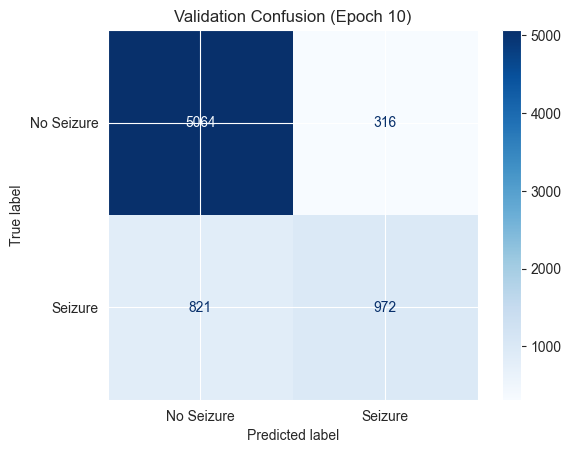

Epoch 11 | Train Loss 0.5618 | Acc 0.7074 | P 0.4499 | R 0.7643 | F1 0.5664 || Val Loss 0.5626 | Acc 0.8366 | P 0.6989 | R 0.6085 | F1 0.6506
Epoch 12 | Train Loss 0.5523 | Acc 0.7257 | P 0.4701 | R 0.7653 | F1 0.5824 || Val Loss 0.5551 | Acc 0.8480 | P 0.7320 | R 0.6185 | F1 0.6705
Epoch 13 | Train Loss 0.5389 | Acc 0.7453 | P 0.4939 | R 0.7665 | F1 0.6007 || Val Loss 0.5569 | Acc 0.8575 | P 0.7787 | R 0.6007 | F1 0.6782
Epoch 14 | Train Loss 0.5291 | Acc 0.7584 | P 0.5111 | R 0.7727 | F1 0.6152 || Val Loss 0.5372 | Acc 0.8602 | P 0.7665 | R 0.6336 | F1 0.6937
Epoch 15 | Train Loss 0.5204 | Acc 0.7680 | P 0.5245 | R 0.7694 | F1 0.6238 || Val Loss 0.5263 | Acc 0.8631 | P 0.7663 | R 0.6509 | F1 0.7039
Epoch 16 | Train Loss 0.5111 | Acc 0.7768 | P 0.5372 | R 0.7737 | F1 0.6341 || Val Loss 0.5224 | Acc 0.8726 | P 0.7956 | R 0.6598 | F1 0.7213
Epoch 17 | Train Loss 0.5043 | Acc 0.7902 | P 0.5581 | R 0.7727 | F1 0.6481 || Val Loss 0.4842 | Acc 0.8209 | P 0.6133 | R 0.7669 | F1 0.6815
Epoch 

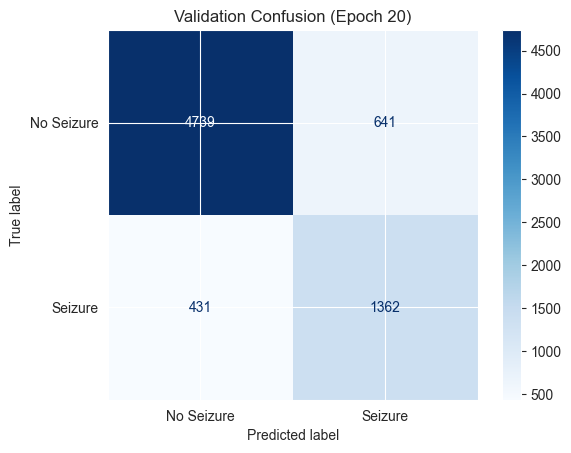

Epoch 21 | Train Loss 0.4786 | Acc 0.8125 | P 0.5936 | R 0.7935 | F1 0.6791 || Val Loss 0.4825 | Acc 0.8793 | P 0.7811 | R 0.7183 | F1 0.7484
Epoch 22 | Train Loss 0.4753 | Acc 0.8157 | P 0.5998 | R 0.7892 | F1 0.6816 || Val Loss 0.4621 | Acc 0.8041 | P 0.5778 | R 0.8031 | F1 0.6721
Epoch 23 | Train Loss 0.4758 | Acc 0.8111 | P 0.5908 | R 0.7947 | F1 0.6777 || Val Loss 0.4782 | Acc 0.8855 | P 0.8007 | R 0.7217 | F1 0.7592
Epoch 24 | Train Loss 0.4708 | Acc 0.8207 | P 0.6080 | R 0.7959 | F1 0.6894 || Val Loss 0.4604 | Acc 0.8754 | P 0.7496 | R 0.7529 | F1 0.7513
Epoch 25 | Train Loss 0.4682 | Acc 0.8199 | P 0.6066 | R 0.7959 | F1 0.6884 || Val Loss 0.4688 | Acc 0.8861 | P 0.7968 | R 0.7306 | F1 0.7623
Epoch 26 | Train Loss 0.4623 | Acc 0.8278 | P 0.6202 | R 0.8031 | F1 0.6999 || Val Loss 0.4710 | Acc 0.8861 | P 0.7998 | R 0.7262 | F1 0.7612
Epoch 27 | Train Loss 0.4619 | Acc 0.8220 | P 0.6101 | R 0.7985 | F1 0.6917 || Val Loss 0.4485 | Acc 0.8673 | P 0.7196 | R 0.7685 | F1 0.7433
Epoch 

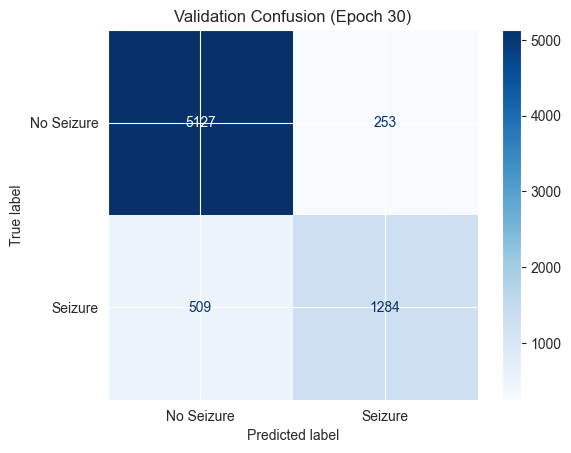

Epoch 31 | Train Loss 0.4539 | Acc 0.8304 | P 0.6243 | R 0.8078 | F1 0.7043 || Val Loss 0.4396 | Acc 0.8539 | P 0.6775 | R 0.7931 | F1 0.7307
Epoch 32 | Train Loss 0.4554 | Acc 0.8293 | P 0.6226 | R 0.8059 | F1 0.7025 || Val Loss 0.4403 | Acc 0.8588 | P 0.6902 | R 0.7892 | F1 0.7364
Epoch 33 | Train Loss 0.4541 | Acc 0.8313 | P 0.6262 | R 0.8071 | F1 0.7052 || Val Loss 0.4705 | Acc 0.8968 | P 0.8390 | R 0.7267 | F1 0.7788
Epoch 34 | Train Loss 0.4487 | Acc 0.8313 | P 0.6262 | R 0.8064 | F1 0.7050 || Val Loss 0.4532 | Acc 0.8892 | P 0.7981 | R 0.7451 | F1 0.7707
Epoch 35 | Train Loss 0.4503 | Acc 0.8330 | P 0.6288 | R 0.8112 | F1 0.7084 || Val Loss 0.4449 | Acc 0.8840 | P 0.7686 | R 0.7669 | F1 0.7677
Epoch 36 | Train Loss 0.4489 | Acc 0.8322 | P 0.6264 | R 0.8150 | F1 0.7084 || Val Loss 0.4545 | Acc 0.8906 | P 0.8036 | R 0.7440 | F1 0.7727
Epoch 37 | Train Loss 0.4449 | Acc 0.8390 | P 0.6406 | R 0.8114 | F1 0.7159 || Val Loss 0.4951 | Acc 0.9003 | P 0.8861 | R 0.6899 | F1 0.7758
Epoch 

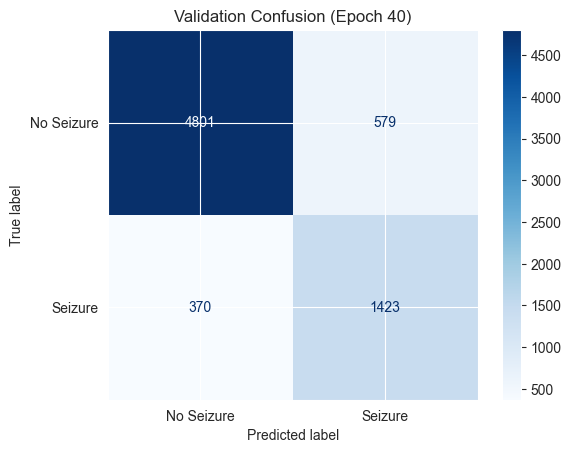

Epoch 41 | Train Loss 0.4408 | Acc 0.8383 | P 0.6385 | R 0.8141 | F1 0.7157 || Val Loss 0.4294 | Acc 0.8582 | P 0.6822 | R 0.8104 | F1 0.7408
Epoch 42 | Train Loss 0.4427 | Acc 0.8380 | P 0.6377 | R 0.8150 | F1 0.7156 || Val Loss 0.4414 | Acc 0.8910 | P 0.7924 | R 0.7641 | F1 0.7780
Epoch 43 | Train Loss 0.4415 | Acc 0.8375 | P 0.6363 | R 0.8169 | F1 0.7154 || Val Loss 0.4534 | Acc 0.8978 | P 0.8338 | R 0.7384 | F1 0.7832
Epoch 44 | Train Loss 0.4415 | Acc 0.8380 | P 0.6381 | R 0.8133 | F1 0.7151 || Val Loss 0.4357 | Acc 0.8899 | P 0.7851 | R 0.7702 | F1 0.7776
Epoch 45 | Train Loss 0.4427 | Acc 0.8335 | P 0.6289 | R 0.8148 | F1 0.7098 || Val Loss 0.4283 | Acc 0.8741 | P 0.7247 | R 0.8003 | F1 0.7607
Epoch 46 | Train Loss 0.4373 | Acc 0.8414 | P 0.6426 | R 0.8236 | F1 0.7219 || Val Loss 0.4329 | Acc 0.8892 | P 0.7748 | R 0.7847 | F1 0.7797
Epoch 47 | Train Loss 0.4365 | Acc 0.8411 | P 0.6430 | R 0.8196 | F1 0.7206 || Val Loss 0.4305 | Acc 0.8761 | P 0.7330 | R 0.7931 | F1 0.7619
Epoch 

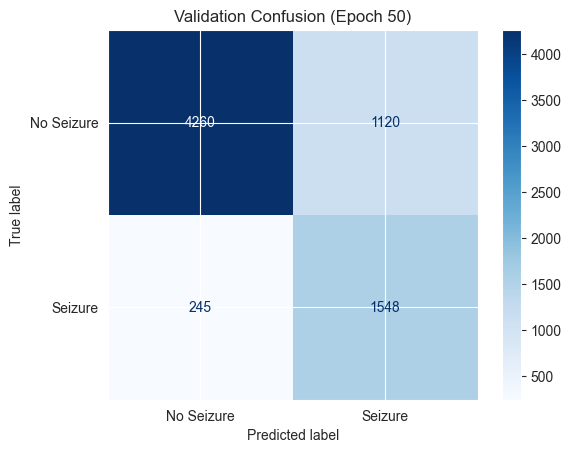

Epoch 51 | Train Loss 0.4347 | Acc 0.8443 | P 0.6477 | R 0.8270 | F1 0.7264 || Val Loss 0.4285 | Acc 0.8805 | P 0.7474 | R 0.7886 | F1 0.7674
Epoch 52 | Train Loss 0.4352 | Acc 0.8435 | P 0.6474 | R 0.8215 | F1 0.7241 || Val Loss 0.4245 | Acc 0.8808 | P 0.7433 | R 0.7992 | F1 0.7702
Epoch 53 | Train Loss 0.4300 | Acc 0.8461 | P 0.6516 | R 0.8265 | F1 0.7287 || Val Loss 0.4312 | Acc 0.8903 | P 0.7801 | R 0.7814 | F1 0.7807
Early stopping at epoch 53 (no F1 improvement for 10 epochs).

Restored best model | Val Acc=0.8978 | F1=0.7832

Final Validation Confusion Matrix:
[[5115  265]
 [ 471 1322]]
TN:5115 FP:265 FN:471 TP:1322
              precision    recall  f1-score   support

  No Seizure     0.9157    0.9507    0.9329      5380
     Seizure     0.8330    0.7373    0.7822      1793

    accuracy                         0.8974      7173
   macro avg     0.8744    0.8440    0.8576      7173
weighted avg     0.8950    0.8974    0.8952      7173



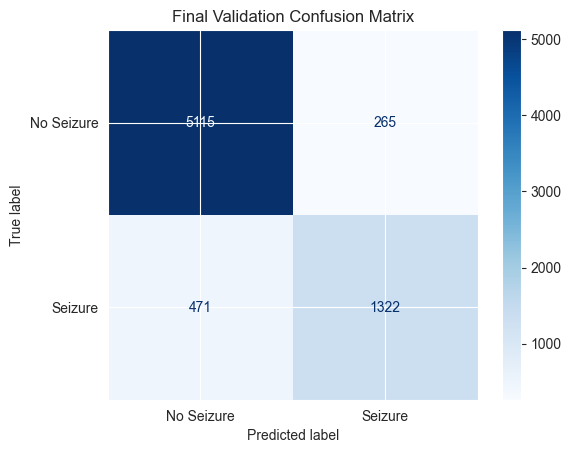

In [28]:
# ============================================================
# HYBRID SNN TRAINING PIPELINE — SIGMA–DELTA + RATE ENCODING

# ============================================================
# MODEL SETUP
# ============================================================
C = X_tr.shape[1]           # EEG channels
n_inputs = 2 * C            # because sigma–delta + rate combined
n_hidden = 192
n_outputs = 2

model = HybridSNN(
    n_inputs=n_inputs,
    n_hidden=n_hidden,
    n_outputs=n_outputs,
    beta=0.97, slope=14.0,
    dropout=0.10, learn_beta=True,
    use_layernorm=True
).to(device)

# Class weights (optional: mild emphasis on seizures)
unique, counts = np.unique(y_tr, return_counts=True)
freq = dict(zip(unique.tolist(), counts.tolist()))
max_c = counts.max()
num_classes = int(unique.max()) + 1
weights = [max_c / freq.get(i, max_c) for i in range(num_classes)]
if num_classes >= 2:
    weights[1] *= 1.2  # slightly more weight on seizure class
class_weights = torch.tensor(weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=8e-4, weight_decay=2e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=8e-4,
    steps_per_epoch=len(train_loader),
    epochs=100, pct_start=0.3
)

CLIP_NORM = 1.0

# ============================================================
# TRAINING LOOP
# ============================================================
EPOCHS = 100
best_val_f1, best_val_acc = 0.0, 0.0
best_state = None
patience, no_improve = 10, 0

for ep in range(1, EPOCHS + 1):
    tr_loss, tr_acc, tr_p, tr_r, tr_f1, _, _ = run_one_epoch(
        model, train_loader, criterion,
        optimizer=optimizer, scheduler=scheduler, clip_norm=CLIP_NORM
    )
    va_loss, va_acc, va_p, va_r, va_f1, y_true, y_pred = run_one_epoch(
        model, val_loader, criterion, optimizer=None
    )

    print(f"Epoch {ep:02d} | Train Loss {tr_loss:.4f} | Acc {tr_acc:.4f} | P {tr_p:.4f} | R {tr_r:.4f} | F1 {tr_f1:.4f} "
          f"|| Val Loss {va_loss:.4f} | Acc {va_acc:.4f} | P {va_p:.4f} | R {va_r:.4f} | F1 {va_f1:.4f}")

    if ep % 10 == 0:
        show_confusion(y_true, y_pred, title=f"Validation Confusion (Epoch {ep})")

    improved = (va_f1 > best_val_f1) or (abs(va_f1 - best_val_f1) <= 1e-6 and va_acc > best_val_acc)
    if improved:
        best_val_f1, best_val_acc = va_f1, va_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {ep} (no F1 improvement for {patience} epochs).")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\nRestored best model | Val Acc={best_val_acc:.4f} | F1={best_val_f1:.4f}")

# ============================================================
# FINAL CONFUSION + CLASSIFICATION REPORT
# ============================================================
with torch.no_grad():
    _, _, _, _, _, y_true, y_pred = run_one_epoch(model, val_loader, criterion, optimizer=None)
show_confusion(y_true, y_pred, title="Final Validation Confusion Matrix")


---

This marks the completion of the **end-to-end Hybrid SNN training pipeline**, enabling robust seizure classification from dual spike-encoded EEG windows.

In [29]:
import time
model.eval()

for xb, yb in train_loader:
    xb, yb = xb.to(device), yb.to(device)
    xb = xb.permute(1, 0, 2).contiguous()    # -> (T,B,2C)

with torch.no_grad():
    t0 = time.perf_counter()
    out = model(xb)     # your input shape (T,B,C)
    t1 = time.perf_counter()

latency_ms = (t1 - t0) * 1000
print(f"Inference latency: {latency_ms:.3f} ms")

Inference latency: 111.029 ms


In [30]:
print(f"Inference latency: {latency_ms/64:.3f} ms")

Inference latency: 1.735 ms


** ROC curve + AUC (window-level)

In [31]:
import numpy as np
import torch
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

@torch.no_grad()
def collect_scores(model, loader, device, pos_index=1):
    """
    Returns:
      y_true: (N,)
      y_score: (N,)  P(y=1|x) from softmax(logits)
    """
    model.eval()
    y_true_list = []
    y_score_list = []

    for xb, yb in loader:
        xb = xb.to(device)  # xb: (B, T, 2C)
        yb = yb.to(device)

        # your model expects (T, B, 2C)
        xb_tm = xb.permute(1, 0, 2).contiguous()
        logits = model(xb_tm)  # (B, 2) for binary

        probs = torch.softmax(logits, dim=1)[:, pos_index]  # P(seizure)
        y_true_list.append(yb.detach().cpu().numpy())
        y_score_list.append(probs.detach().cpu().numpy())

    y_true = np.concatenate(y_true_list).astype(int)
    y_score = np.concatenate(y_score_list).astype(float)
    return y_true, y_score

# ROC curve
y_true, y_score = collect_scores(model, val_loader, device)

# ROC + AUC
fpr, tpr, thr = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)
print(f"ROC-AUC: {roc_auc:.4f}")

# (Optional but recommended) PR-AUC for imbalance
prec, rec, pr_thr = precision_recall_curve(y_true, y_score)
pr_auc = average_precision_score(y_true, y_score)
print(f"PR-AUC: {pr_auc:.4f}")
def plot_roc(y_true, y_score, title="ROC Curve (Window-level)"):
    """
    y_true  : (N,) ground-truth labels {0,1}
    y_score : (N,) model seizure probabilities
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return fpr, tpr, thresholds, auc


ROC-AUC: 0.9047
PR-AUC: 0.8575


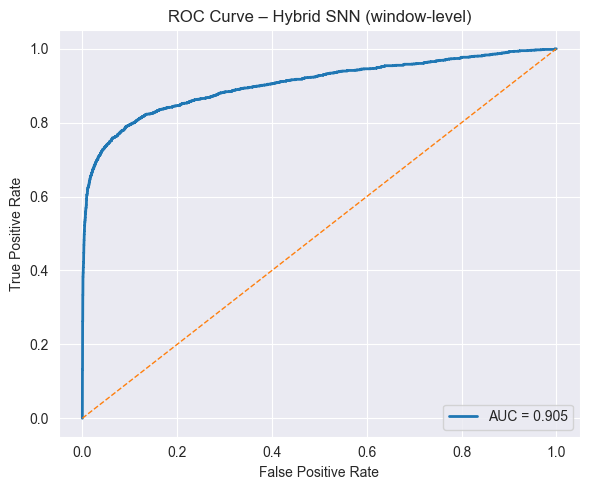

In [32]:
fpr, tpr, thresholds, auc = plot_roc(
    y_true=y_true,
    y_score=y_score,
    title="ROC Curve – Hybrid SNN (window-level)"
)


FP/day using streaming alarm logic (k-of-n) + overlapped windows

This computes false alarms per day as number of false alarm events/day (alarm onsets during non-seizure windows), which is what reviewers typically mean by FP/day.

In [33]:
def k_of_n_alarm(y_score, threshold=0.5, k=3, n=8):
    """
    y_score: (N,) seizure probabilities in chronological order
    Returns alarm state per window: (N,) {0,1}
    """
    y_hat = (y_score >= threshold).astype(np.int32)

    # rolling sum over last n windows
    roll = np.convolve(y_hat, np.ones(n, dtype=np.int32), mode="full")[:len(y_hat)]
    # roll[t] = sum_{i=max(0,t-n+1)..t} y_hat[i]
    alarm = (roll >= k).astype(np.int32)
    return alarm

def false_alarms_per_day(y_true, y_score, stride_sec, threshold=0.5, k=3, n=8):
    """
    Counts alarm EVENTS (0->1 transitions) that occur when y_true==0.
    Converts to FP/day using total evaluated duration.
    """
    alarm = k_of_n_alarm(y_score, threshold=threshold, k=k, n=n)

    # alarm onsets (event count)
    onset = (alarm[1:] == 1) & (alarm[:-1] == 0)
    onset_idx = np.where(onset)[0] + 1

    # false alarm onsets: alarm starts during non-seizure-labeled window
    fa_events = np.sum(y_true[onset_idx] == 0)

    total_seconds = len(y_true) * stride_sec
    days = total_seconds / 86400.0
    fp_day = fa_events / days if days > 0 else np.nan

    return fp_day, fa_events, days

# Your stride with 0.5s windows and 50% overlap is 0.25s:
stride_sec = 0.25

fp_day, fa_events, days = false_alarms_per_day(
    y_true=y_true,
    y_score=y_score,
    stride_sec=stride_sec,
    threshold=0.5,  # choose/report threshold or sweep
    k=3, n=8        # example: 3 positives in last 8 windows (~2.0s span with 0.25s stride)
)

print(f"False alarms/day: {fp_day:.3f}  (FA events={fa_events}, duration_days={days:.3f})")


False alarms/day: 3131.744  (FA events=65, duration_days=0.021)


Average input spike rate (sigma-delta vs rate vs combined)

This computes mean spike probability in the input spike tensor as delivered by your dataset:

sigma-delta stream = first C channels of the 2C

rate stream = last C

combined = all 2C

In [34]:
@torch.no_grad()
def input_spike_rates(loader, device):
    """
    Returns mean spike rate for:
      - sigma-delta stream
      - rate stream
      - combined
    Averages over batch, time, and channels.
    """
    total_sd = 0.0
    total_rt = 0.0
    total_all = 0.0
    count = 0  # number of samples * time steps * channels (handled via tensor size)

    for xb, yb in loader:
        xb = xb.to(device)  # (B, T, 2C)
        B, T, twoC = xb.shape
        C = twoC // 2

        sd = xb[:, :, :C]
        rt = xb[:, :, C:]

        total_sd += sd.sum().item()
        total_rt += rt.sum().item()
        total_all += xb.sum().item()

        count += B * T * C  # per-stream count; combined is 2x this

    mean_sd = total_sd / count
    mean_rt = total_rt / count
    mean_all = total_all / (count * 2)

    return mean_sd, mean_rt, mean_all

sd_rate, rt_rate, all_rate = input_spike_rates(val_loader, device)
print(f"Mean input spike rate (sigma-delta): {sd_rate:.6f}")
print(f"Mean input spike rate (rate code):    {rt_rate:.6f}")
print(f"Mean input spike rate (combined):     {all_rate:.6f}")


Mean input spike rate (sigma-delta): 0.203928
Mean input spike rate (rate code):    0.498521
Mean input spike rate (combined):     0.351225


Step 1: Convert scores to window-level detections     

Step 2: Detect seizure events (≥ 10 consecutive windows)

Step 3: Count false-positive seizure events

Step 4: Compute FP/hour and FP/day





In [35]:
def window_predictions(y_score, threshold=0.5):
    """
    Convert probabilities to binary window-level predictions.
    """
    return (y_score >= threshold).astype(np.int32)


def detect_seizure_events(y_hat, min_consecutive=10):
    """
    Detect seizure events as runs of >= min_consecutive ones.

    Returns:
      event_onsets: indices where seizure events start
      event_offsets: indices where seizure events end
    """
    event_onsets = []
    event_offsets = []

    count = 0
    start = None

    for i, v in enumerate(y_hat):
        if v == 1:
            if count == 0:
                start = i
            count += 1
            if count == min_consecutive:
                event_onsets.append(start)
        else:
            if count >= min_consecutive:
                event_offsets.append(i - 1)
            count = 0
            start = None

    # handle case where stream ends during seizure
    if count >= min_consecutive:
        event_offsets.append(len(y_hat) - 1)

    return event_onsets, event_offsets


def count_false_alarms(event_onsets, y_true):
    """
    Count seizure events whose onset occurs during non-seizure ground truth.
    """
    false_alarms = 0
    for onset in event_onsets:
        if y_true[onset] == 0:
            false_alarms += 1
    return false_alarms

def fp_rate(y_true, y_score, threshold=0.5,
            min_consecutive=10, stride_sec=0.25):
    """
    Returns:
      FP_per_hour
      FP_per_day
      total_false_alarms
      total_hours
    """
    y_hat = window_predictions(y_score, threshold)
    onsets, offsets = detect_seizure_events(y_hat, min_consecutive)

    false_alarms = count_false_alarms(onsets, y_true)

    total_seconds = len(y_true) * stride_sec
    total_hours = total_seconds / 3600.0
    total_days = total_seconds / 86400.0

    fp_per_hour = false_alarms / total_hours if total_hours > 0 else np.nan
    fp_per_day = false_alarms / total_days if total_days > 0 else np.nan

    return fp_per_hour, fp_per_day, false_alarms, total_hours




In [45]:
fp_hr, fp_day, fa_events, hours = fp_rate(
    y_true=y_true,
    y_score=y_score,
    threshold=3,
    min_consecutive=3,
    stride_sec=15
)

print(f"False alarms/hour: {fp_hr:.3f}")
print(f"False alarms/day:  {fp_day:.3f}")
print(f"Total false alarms: {fa_events}")
print(f"Total evaluated hours: {hours:.2f}")

False alarms/hour: 0.000
False alarms/day:  0.000
Total false alarms: 0
Total evaluated hours: 29.89
